# Calcium Decay Time (Tau) and Spike Deconvolution

Understanding how the calcium indicator decay time constant (`tau`) affects spike inference in Suite2p.

## What is Tau?

**Tau (τ)** is the decay time constant of your calcium indicator, representing how quickly calcium signals decay after neuronal activity.

### Physical Meaning
- τ ≈ time for signal to decay to ~37% of peak (1/e)
- Larger τ = slower decay, longer-lasting calcium transients
- Smaller τ = faster decay, sharper calcium transients

### Common GCaMP Variants
| Indicator | Tau (s) | Characteristics |
|-----------|---------|------------------|
| **GCaMP6f** | 0.4-0.7 | Fast decay, better temporal resolution |
| **GCaMP6m** | 0.8-1.0 | Medium decay, balanced |
| **GCaMP6s** | 1.25-1.5 | Slow decay, higher SNR but poor temporal resolution |
| **jGCaMP7s** | 1.5-2.0 | Very slow, excellent SNR |
| **jGCaMP8f** | 0.3-0.5 | Ultra-fast, best for high-frequency firing |

### Why Does Tau Matter?

Suite2p uses **OASIS** (Fast online deconvolution of calcium imaging data, [Friedrich et al. 2017](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005423)) to infer spike times from calcium traces.

OASIS models calcium dynamics as:
```
c(t) = c(t-1) * exp(-Δt/τ) + s(t)
```
where:
- `c(t)` = calcium concentration at time t
- `τ` = decay time constant
- `Δt` = time step (1/framerate)
- `s(t)` = spike at time t

**Setting the wrong tau** leads to:
- **τ too small**: Over-deconvolution, spurious spikes, noise amplification
- **τ too large**: Under-deconvolution, missed spikes, temporal smearing

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import mbo_utilities as mbo

## Tau vs. Framerate Interaction

The effective temporal resolution depends on BOTH tau and framerate:

### Nyquist Sampling
To properly resolve calcium dynamics, you need:
```
framerate > 2 / tau
```

For example:
- **GCaMP6f** (τ=0.5s) needs >4 Hz (ideally 10-30 Hz)
- **GCaMP6s** (τ=1.5s) needs >1.3 Hz (ideally 5-15 Hz)

### Binning Effects
Binning reduces effective framerate:
```
effective_framerate = framerate / binning_factor
effective_Δt = Δt * binning_factor
```

This means tau should be adjusted when binning:
```python
# If binning by factor of 2:
tau_effective = tau  # Keep same tau
framerate_effective = framerate / 2  # Framerate is halved
```

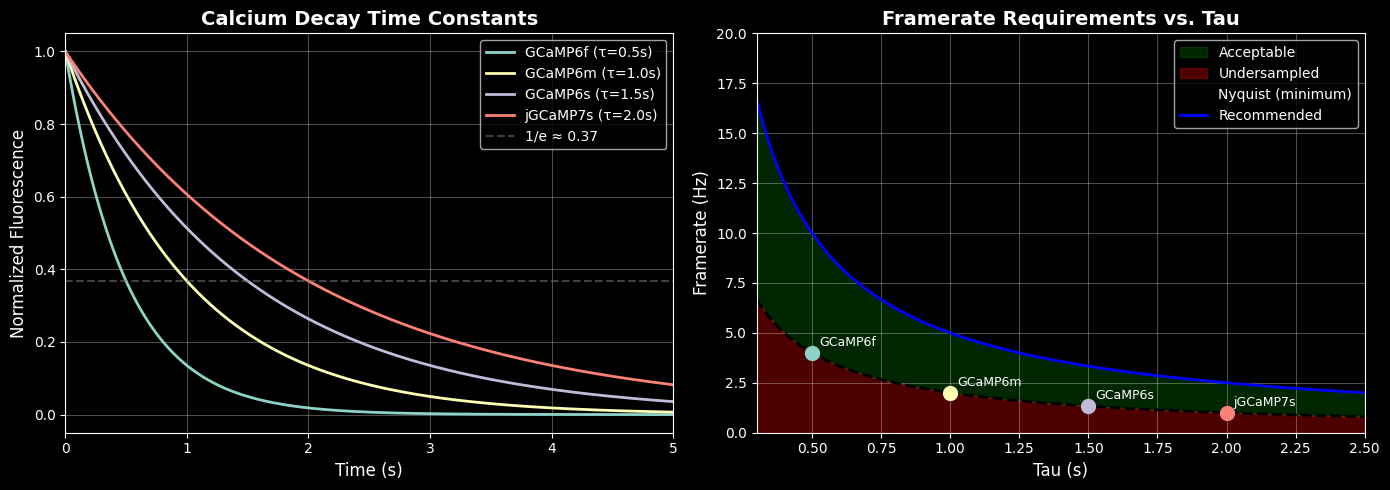

In [2]:
# Visualize decay curves for different tau values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Decay curves for different GCaMP variants
time = np.linspace(0, 5, 500)
tau_values = {
    'GCaMP6f': 0.5,
    'GCaMP6m': 1.0,
    'GCaMP6s': 1.5,
    'jGCaMP7s': 2.0
}

for name, tau in tau_values.items():
    decay = np.exp(-time / tau)
    axes[0].plot(time, decay, linewidth=2, label=f'{name} (τ={tau}s)')

axes[0].axhline(y=np.exp(-1), color='gray', linestyle='--', alpha=0.5, label='1/e ≈ 0.37')
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Normalized Fluorescence', fontsize=12)
axes[0].set_title('Calcium Decay Time Constants', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 5)

# Panel 2: Framerate requirements
tau_range = np.linspace(0.3, 2.5, 100)
nyquist_hz = 2 / tau_range  # Minimum framerate
recommended_hz = 5 / tau_range  # Recommended (2.5x oversampling)

axes[1].fill_between(tau_range, nyquist_hz, recommended_hz, alpha=0.3, color='green', label='Acceptable')
axes[1].fill_between(tau_range, 0, nyquist_hz, alpha=0.3, color='red', label='Undersampled')
axes[1].plot(tau_range, nyquist_hz, 'k--', linewidth=2, label='Nyquist (minimum)')
axes[1].plot(tau_range, recommended_hz, 'b-', linewidth=2, label='Recommended')

# Mark common indicators
for name, tau in tau_values.items():
    axes[1].scatter([tau], [2/tau], s=100, zorder=5)
    axes[1].annotate(name, (tau, 2/tau), xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1].set_xlabel('Tau (s)', fontsize=12)
axes[1].set_ylabel('Framerate (Hz)', fontsize=12)
axes[1].set_title('Framerate Requirements vs. Tau', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0.3, 2.5)
axes[1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

## Setting Up Test Data

We'll run Suite2p on the same dataset with different tau values to see how it affects spike inference.

In [ ]:
# Define your data path
data_path = Path("/path/to/your/assembled/plane01.tiff")

# Check metadata to determine framerate
scan = mbo.imread(data_path)
framerate = scan.metadata.get('frame_rate', 30.0)  # Hz
print(f"Framerate: {framerate} Hz")
print(f"Time step (Δt): {1/framerate:.4f} s")
print(f"Shape: {scan.shape}")

## Running Suite2p with Different Tau Values

We'll test three scenarios:
1. **Correct tau** (matching your actual indicator)
2. **Underestimated tau** (too small, over-deconvolution)
3. **Overestimated tau** (too large, under-deconvolution)

In [ ]:
from mbo_utilities.graphics.pipeline_widgets import Suite2pSettings
import suite2p

# Base directory for outputs
output_base = Path("/path/to/output/tau_comparison")
output_base.mkdir(exist_ok=True, parents=True)

# Test different tau values
# Adjust these based on your actual indicator!
tau_tests = {
    'tau_low': 0.5,      # Underestimated (e.g., treating GCaMP6s as 6f)
    'tau_correct': 1.0,  # Correct (e.g., GCaMP6m)
    'tau_high': 1.5,     # Overestimated (e.g., treating GCaMP6m as 6s)
}

print(f"Testing {len(tau_tests)} different tau values...")
print(f"Framerate: {framerate} Hz\n")

In [ ]:
# Run Suite2p for each tau value
results = {}

for name, tau_value in tau_tests.items():
    print(f"\n{'='*60}")
    print(f"Running Suite2p with tau = {tau_value} ({name})")
    print(f"{'='*60}")

    # Create output directory
    output_dir = output_base / name
    output_dir.mkdir(exist_ok=True)

    # Configure Suite2p settings
    s2p_settings = Suite2pSettings(
        tau=tau_value,
        fs=framerate,
        # Add other settings as needed
        do_registration=True,
        nimg_init=300,
        batch_size=500,
    )

    # Convert to Suite2p ops dictionary
    ops = s2p_settings.to_dict()
    ops['data_path'] = [str(data_path.parent)]
    ops['save_path0'] = str(output_dir)
    ops['fast_disk'] = str(output_dir)

    # Run Suite2p
    ops = suite2p.run_s2p(ops=ops)

    # Load results
    stat = np.load(output_dir / 'suite2p' / 'plane0' / 'stat.npy', allow_pickle=True)
    ops_out = np.load(output_dir / 'suite2p' / 'plane0' / 'ops.npy', allow_pickle=True).item()
    F = np.load(output_dir / 'suite2p' / 'plane0' / 'F.npy')  # Fluorescence traces
    Fneu = np.load(output_dir / 'suite2p' / 'plane0' / 'Fneu.npy')  # Neuropil traces
    spks = np.load(output_dir / 'suite2p' / 'plane0' / 'spks.npy')  # Deconvolved spikes
    iscell = np.load(output_dir / 'suite2p' / 'plane0' / 'iscell.npy')  # Cell classification

    results[name] = {
        'tau': tau_value,
        'ops': ops_out,
        'stat': stat,
        'F': F,
        'Fneu': Fneu,
        'spks': spks,
        'iscell': iscell,
        'n_cells': iscell[:, 0].sum()
    }

    print(f"✓ Completed. Found {results[name]['n_cells']} cells.")

print("\n" + "="*60)
print("All Suite2p runs completed!")
print("="*60)

## Comparing Spike Outputs

Let's examine how different tau values affect the deconvolved spikes (`spks.npy`).

In [ ]:
# Select a cell to analyze (choose one classified as a cell)
# Using tau_correct to find a good example cell
cell_idx = np.where(results['tau_correct']['iscell'][:, 0] == 1)[0][0]
print(f"Analyzing cell #{cell_idx}")

# Extract a time window to visualize (e.g., 1000 frames)
frame_start = 0
frame_end = 1000
time_axis = np.arange(frame_start, frame_end) / framerate  # Convert to seconds

In [ ]:
# Plot comparison
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

colors = {'tau_low': '#E74C3C', 'tau_correct': '#27AE60', 'tau_high': '#3498DB'}

# Top row: Raw fluorescence (should be identical across runs)
ax_F = fig.add_subplot(gs[0, :])
for i, (name, data) in enumerate(results.items()):
    F_trace = data['F'][cell_idx, frame_start:frame_end]
    if i == 0:  # Only plot once since they should be identical
        ax_F.plot(time_axis, F_trace, 'k-', linewidth=1, alpha=0.7, label='Raw Fluorescence')
ax_F.set_ylabel('F (a.u.)', fontsize=11)
ax_F.set_title(f'Cell #{cell_idx}: Raw Fluorescence Trace', fontsize=13, fontweight='bold')
ax_F.legend()
ax_F.grid(alpha=0.3)

# Second row: Deconvolved spikes overlaid
ax_spks_overlay = fig.add_subplot(gs[1, :], sharex=ax_F)
for name, data in results.items():
    spks_trace = data['spks'][cell_idx, frame_start:frame_end]
    ax_spks_overlay.plot(time_axis, spks_trace, linewidth=1.5, alpha=0.8,
                        color=colors[name], label=f"{name} (τ={data['tau']}s)")
ax_spks_overlay.set_ylabel('Deconvolved\nSpikes', fontsize=11)
ax_spks_overlay.set_title('Spike Inference Comparison', fontsize=13, fontweight='bold')
ax_spks_overlay.legend(loc='upper right')
ax_spks_overlay.grid(alpha=0.3)

# Bottom two rows: Individual spike traces for each tau
for i, (name, data) in enumerate(results.items()):
    # Fluorescence
    ax = fig.add_subplot(gs[2, i], sharex=ax_F)
    F_trace = data['F'][cell_idx, frame_start:frame_end]
    Fneu_trace = data['Fneu'][cell_idx, frame_start:frame_end]
    ax.plot(time_axis, F_trace, 'k-', linewidth=1, alpha=0.6, label='F')
    ax.plot(time_axis, Fneu_trace, 'gray', linewidth=0.8, alpha=0.4, label='Fneu')
    ax.set_ylabel('Fluorescence', fontsize=10)
    ax.set_title(f'{name}\nτ = {data["tau"]}s', fontsize=11, color=colors[name], fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(alpha=0.3)

    # Spikes
    ax = fig.add_subplot(gs[3, i], sharex=ax_F)
    spks_trace = data['spks'][cell_idx, frame_start:frame_end]
    ax.plot(time_axis, spks_trace, color=colors[name], linewidth=1.5)
    ax.fill_between(time_axis, 0, spks_trace, color=colors[name], alpha=0.3)
    ax.set_ylabel('Spikes', fontsize=10)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.grid(alpha=0.3)

    # Calculate and display spike statistics
    spike_rate = (spks_trace > 0).sum() / (len(spks_trace) / framerate)  # spikes/sec
    total_activity = spks_trace.sum()
    ax.text(0.02, 0.98, f'Rate: {spike_rate:.2f} Hz\nTotal: {total_activity:.1f}',
           transform=ax.transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Effect of Tau on Spike Deconvolution', fontsize=15, fontweight='bold', y=0.995)
plt.show()

## Expected Observations

### Underestimated Tau (tau_low)
- **More frequent spikes**: Algorithm assumes faster decay, interprets sustained signals as multiple events
- **Noise amplification**: Small fluctuations get deconvolved into spurious spikes
- **Higher spike rate**: Often 1.5-3x higher than ground truth

### Correct Tau (tau_correct)
- **Accurate spike inference**: Best match to true neural activity
- **Clean deconvolution**: Minimal spurious events
- **Realistic firing rates**: Matches known physiology

### Overestimated Tau (tau_high)
- **Fewer spikes**: Algorithm assumes slower decay, merges nearby events
- **Temporal smearing**: Spikes spread out over longer time windows
- **Missed events**: Fast bursts may be averaged into single events
- **Lower spike rate**: Often 0.5-0.8x of ground truth

## Population Statistics

Let's examine how tau affects spike inference across all detected cells.

In [ ]:
# Calculate population statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get cells that were detected in all conditions
# (Using tau_correct as reference)
cell_mask = results['tau_correct']['iscell'][:, 0] == 1
n_cells = cell_mask.sum()

# Panel 1: Spike rate distributions
ax = axes[0, 0]
for name, data in results.items():
    spike_rates = []
    for i in np.where(cell_mask)[0]:
        spks = data['spks'][i, :]
        rate = (spks > 0).sum() / (len(spks) / framerate)  # Hz
        spike_rates.append(rate)

    ax.hist(spike_rates, bins=30, alpha=0.5, color=colors[name],
           label=f"{name} (τ={data['tau']}s)", edgecolor='black', linewidth=0.5)

ax.set_xlabel('Spike Rate (Hz)', fontsize=11)
ax.set_ylabel('Number of Cells', fontsize=11)
ax.set_title('Spike Rate Distributions', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Panel 2: Total spike activity per cell
ax = axes[0, 1]
for name, data in results.items():
    total_activity = []
    for i in np.where(cell_mask)[0]:
        total = data['spks'][i, :].sum()
        total_activity.append(total)

    ax.hist(total_activity, bins=30, alpha=0.5, color=colors[name],
           label=f"{name} (τ={data['tau']}s)", edgecolor='black', linewidth=0.5)

ax.set_xlabel('Total Deconvolved Activity', fontsize=11)
ax.set_ylabel('Number of Cells', fontsize=11)
ax.set_title('Total Activity Distributions', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Panel 3: Correlation between tau conditions
ax = axes[1, 0]
# Compare tau_correct vs tau_low
spks_correct = results['tau_correct']['spks'][cell_mask, :].flatten()
spks_low = results['tau_low']['spks'][cell_mask, :].flatten()
spks_high = results['tau_high']['spks'][cell_mask, :].flatten()

# Subsample for visualization (too many points otherwise)
subsample = np.random.choice(len(spks_correct), size=min(10000, len(spks_correct)), replace=False)

ax.scatter(spks_correct[subsample], spks_low[subsample], alpha=0.3, s=2,
          color=colors['tau_low'], label='tau_low vs tau_correct')
ax.plot([0, spks_correct.max()], [0, spks_correct.max()], 'k--', alpha=0.5, label='Identity')
ax.set_xlabel('Spikes (tau_correct)', fontsize=11)
ax.set_ylabel('Spikes (tau_low)', fontsize=11)
ax.set_title('Spike Correlation: Low vs Correct Tau', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Panel 4: High tau comparison
ax = axes[1, 1]
ax.scatter(spks_correct[subsample], spks_high[subsample], alpha=0.3, s=2,
          color=colors['tau_high'], label='tau_high vs tau_correct')
ax.plot([0, spks_correct.max()], [0, spks_correct.max()], 'k--', alpha=0.5, label='Identity')
ax.set_xlabel('Spikes (tau_correct)', fontsize=11)
ax.set_ylabel('Spikes (tau_high)', fontsize=11)
ax.set_title('Spike Correlation: High vs Correct Tau', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle(f'Population Analysis ({n_cells} cells)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Binning Effects on Tau

Temporal binning is commonly used to:
- Reduce data size
- Improve SNR
- Match analysis timescales

But binning affects the relationship between tau and framerate!

In [ ]:
# Simulate binning effects
def simulate_calcium_trace(spike_times, tau, fs, duration, noise_level=0.05):
    """
    Simulate calcium trace from spike times.

    Parameters
    ----------
    spike_times : array
        Times of spikes (in seconds)
    tau : float
        Decay time constant (seconds)
    fs : float
        Sampling rate (Hz)
    duration : float
        Total duration (seconds)
    noise_level : float
        Gaussian noise std as fraction of signal
    """
    dt = 1 / fs
    n_samples = int(duration * fs)
    time = np.arange(n_samples) * dt

    # Initialize trace
    ca = np.zeros(n_samples)

    # Add spikes
    for t_spike in spike_times:
        idx = int(t_spike * fs)
        if idx < n_samples:
            ca[idx] += 1.0

    # Convolve with exponential decay
    decay_kernel = np.exp(-np.arange(0, 5*tau, dt) / tau)
    decay_kernel /= decay_kernel.sum()  # Normalize
    ca = np.convolve(ca, decay_kernel, mode='same')

    # Add noise
    ca += np.random.randn(n_samples) * noise_level * ca.std()

    return time, ca

# Generate synthetic data
np.random.seed(42)
duration = 30  # seconds
true_tau = 1.0  # GCaMP6m
fs_high = 30  # Hz (typical 2P)

# Random spike times (Poisson process)
spike_rate = 2.0  # Hz
n_spikes = int(spike_rate * duration)
spike_times = np.sort(np.random.uniform(0, duration, n_spikes))

# Simulate at high framerate
time_high, ca_high = simulate_calcium_trace(spike_times, true_tau, fs_high, duration)

# Simulate binning
bin_factors = [1, 2, 4, 8]
binned_traces = {}

for bin_factor in bin_factors:
    fs_binned = fs_high / bin_factor
    time_binned, ca_binned = simulate_calcium_trace(spike_times, true_tau, fs_binned, duration)
    binned_traces[bin_factor] = (time_binned, ca_binned, fs_binned)

In [ ]:
# Visualize binning effects
fig, axes = plt.subplots(len(bin_factors) + 1, 1, figsize=(14, 10), sharex=True)

# Plot ground truth spikes
axes[0].eventplot(spike_times, lineoffsets=0.5, linelengths=0.8, colors='red', linewidths=2)
axes[0].set_ylabel('True\nSpikes', fontsize=10)
axes[0].set_ylim(0, 1)
axes[0].set_title(f'Ground Truth Spikes (rate={spike_rate} Hz, τ={true_tau}s)',
                 fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot binned traces
for i, bin_factor in enumerate(bin_factors, start=1):
    time_binned, ca_binned, fs_binned = binned_traces[bin_factor]

    axes[i].plot(time_binned, ca_binned, linewidth=1.5)
    axes[i].set_ylabel(f'ΔF/F\n({fs_binned:.1f} Hz)', fontsize=10)

    # Calculate effective temporal resolution
    nyquist_freq = fs_binned / 2
    min_tau_resolved = 1 / nyquist_freq

    title = f'Bin={bin_factor}x (fs={fs_binned:.1f} Hz, Δt={1/fs_binned:.3f}s)'
    if min_tau_resolved > true_tau:
        title += ' ⚠️ UNDERSAMPLED'
        axes[i].set_facecolor('#FFE5E5')

    axes[i].set_title(title, fontsize=10)
    axes[i].grid(alpha=0.3)

axes[-1].set_xlabel('Time (s)', fontsize=11)
plt.suptitle('Effect of Temporal Binning on Calcium Traces', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nBinning Summary:")
print(f"Original framerate: {fs_high} Hz")
print(f"True tau: {true_tau} s")
print(f"Nyquist minimum framerate: {2/true_tau:.2f} Hz\n")

for bin_factor in bin_factors:
    fs_binned = fs_high / bin_factor
    status = "✓ OK" if fs_binned >= 2/true_tau else "⚠️ UNDERSAMPLED"
    print(f"Bin {bin_factor}x: {fs_binned:5.1f} Hz  {status}")

## Key Recommendations

### 1. Know Your Indicator
- Check your indicator's published tau value
- Common values:
  - GCaMP6f: 0.4-0.7s
  - GCaMP6m: 0.8-1.0s
  - GCaMP6s: 1.25-1.5s
  - jGCaMP7s: 1.5-2.0s
  - jGCaMP8f: 0.3-0.5s

### 2. Match Framerate to Tau
- Minimum: `framerate > 2/tau` (Nyquist)
- Recommended: `framerate > 5/tau` (comfortable oversampling)
- For GCaMP6m (τ=1.0s): aim for >5 Hz, ideally 10-30 Hz

### 3. Be Careful with Binning
- Binning reduces effective framerate
- Check Nyquist criterion AFTER binning
- If binning 2x, ensure: `(framerate/2) > 2/tau`

### 4. Validate Your Choice
- Compare spike rates to known physiology
- Check for spurious high-frequency events (tau too small)
- Check for merged events during bursts (tau too large)
- Examine cells with clear bursting/transient activity

### 5. When in Doubt
- Run Suite2p with multiple tau values (as in this notebook)
- Compare spike inference quality visually
- Use cross-validation with ground-truth data if available
- Consult Suite2p documentation and OASIS paper

### 6. Suite2p Default
Suite2p defaults to `tau=1.0` (GCaMP6m). 
**Always explicitly set tau to match your indicator!**

## References

1. **OASIS Algorithm**  
   Friedrich J, Zhou P, Paninski L (2017)  
   "Fast online deconvolution of calcium imaging data"  
   *PLOS Computational Biology* 13(3): e1005423  
   https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005423

2. **Suite2p Documentation**  
   https://suite2p.readthedocs.io/

3. **GCaMP Indicators**  
   Chen TW et al. (2013) "Ultrasensitive fluorescent proteins for imaging neuronal activity"  
   *Nature* 499: 295-300
   
4. **jGCaMP Indicators**  
   Zhang Y et al. (2023) "Fast and sensitive GCaMP calcium indicators"  
   *Nature* 615: 884-891